# Question 2 (50 points)
***In this question, you will simulate a peptide design experiment, trying to find peptides with high binding affinity to MHC class I using a Bayesian Optimization approach. Notice the goal here is not trying to find a peptide sequence that maximize the binding affinity to MHC, since a sizable proportion of the sequence data we are using contains maximum binding affinity out of the data (9.0). Using the same feature encoding as Question 1, we will examine several techniques to maximize the percentage of sequence with affinity of 9.0 for stringent querying.***

**TODO**
- **Complete the code under `### TO DO` in each cell and produce the required plots. Feel free to define any helper functions as you see fit.**

### Imports and Setup

In [10]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF
from sklearn.ensemble import RandomForestRegressor

from modAL.models import BayesianOptimizer
from modAL.acquisition import max_EI

from scipy import sparse

import seqlogo

import copy

# custom package
from packages.activelearning import activelearning as al

### Set random seed
seed = 5
random.seed(seed)
np.random.seed(seed)

### Suppresses Warning
import warnings
warnings.filterwarnings('ignore')

# 2.0. Reading and Processing the Data

### Load Data

In [11]:
data = pd.read_csv('data/hw3_data.csv', delimiter=',',header=0)
print(data.shape)
data.head(5)

(9051, 4)


,id,allele,seq,pIC50
0,seq0,HLA-A*02:01,AIIDYIAYM,9.0
1,seq1,HLA-A*02:01,AIYDTMQYV,9.0
2,seq2,HLA-A*02:01,ALATFTVNI,9.0
3,seq3,HLA-A*02:01,ALDEGLLPV,9.0
4,seq4,HLA-A*02:01,ALFPIIWAL,9.0


### Encode Data

In [12]:
# create separate columns for each amino acid
for i in range(9):
    colname='seq'+str(i)
    data[colname] = [x[i] for x in data['seq']]

In [13]:
data.head(1)

,id,allele,seq,pIC50,seq0,seq1,seq2,seq3,seq4,seq5,seq6,seq7,seq8
0,seq0,HLA-A*02:01,AIIDYIAYM,9.0,A,I,I,D,Y,I,A,Y,M


In [14]:
X_df = data.drop(['pIC50','id','allele', 'seq'],axis=1)
y = data['pIC50']
print(X_df.shape)
print(y.shape)

(9051, 9)
(9051,)


In [15]:
X_df.head(1)

,seq0,seq1,seq2,seq3,seq4,seq5,seq6,seq7,seq8
0,A,I,I,D,Y,I,A,Y,M


In [16]:
enc = OneHotEncoder(handle_unknown='ignore')
X_enc = enc.fit_transform(X_df)
print(type(X_enc))
print(X_enc.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(9051, 180)


In [17]:
# convert to numpy array
X_pool=sparse.csr_matrix.toarray(X_enc)
print(type(X_pool))
print(X_pool.shape)
y_pool = y.to_numpy()
print(y_pool.shape)

<class 'numpy.ndarray'>
(9051, 180)
(9051,)


# 2.1. Random Sampling (5 points) 

**TODO**
- **Create a random query strategy for randomly selecting a sample to query from the data. If the data selected is a new sequence with binding affinity of 9.0, append it to a list.**
- **After each query selection, measure the percentage of sequence with binding affinity 9.0 found by the strategy. Do this for 200 sampling steps. This will serve as the baseline to compare with optimizator performance in section 2.2 and 2.3.**

In [18]:
def calculate_percent(n_optimal, n_attempts):
    '''
    Measures the percentage of sequences with binding affinity 9.0 found by the strategy to this point.
    '''
    return n_optimal / 354  # n_found out of total number of 9.0 samples, per Piazza post
   
# print('test calculate_percent()')
# assert calculate_percent(2,5) == 0.4

In [19]:
%%time

# copy data for this section
X_cp = copy.deepcopy(X_pool)
y_cp = copy.deepcopy(y_pool)

history_rand = [0]  # history of success / attempts
optimal_points_rand = []

n_queries = 200
for q in range(n_queries):
    
    # select random point 
    query_idx = np.random.choice(len(X_cp))
    
    # remove queried point from pool
    X_cp = np.delete(X_cp, query_idx, axis=0)
    y_cp = np.delete(y_cp, query_idx)
    
    # check if pIC50 meets requirements for retention
    if y_cp[query_idx] == 9.0:
        optimal_points_rand.append(X_cp[query_idx])
        
    # calculate percent of sequences found by the strategy
    percent = calculate_percent(len(optimal_points_rand), q+1)
    history_rand.append(percent)
        
len(optimal_points_rand)


CPU times: user 492 ms, sys: 150 ms, total: 643 ms
Wall time: 645 ms


12

# 2.2. Bayesian Optimization with Gaussian Process (15 points)

**TODO**
- **Create a Baysian optimizer with Gaussian process as regressor and Max Expected improvement as the queuing strategy.**
- **If the data selected is a new sequence with binding affinity of 9.0, append it to a list.**
- **After each query selection, measure the percentage of sequence with binding affinity 9.0 found by the strategy.** 
- **Do this for 200 sampling steps.** 

**Hint: Check the modAL [documentation](https://modal-python.readthedocs.io/en/latest/content/examples/bayesian_optimization.html#Optimizing-using-expected-improvement) for how to set up a Baysian optimizer.**

In [20]:
# I used a function from the same custom Python package I used in Q1

In [41]:
def run_bayesian_optimization(optimizer, X_pool, y_pool, n_queries):
    
    percent_history = [0]
    optimal_points = []

    for q in range(n_queries):
        
        # 1 - active learning steps
        # get sample
        X_sample, y_sample, query_idx = al.get_next_sample(optimizer, X_pool, y_pool)

        # use new sample to update the model
        optimizer.teach(X_sample, y_sample)
        
        # remove queried point from pool
        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx)

        # 2 - metric collection
        # check if sample meets criteria for saving
        if y_sample == 9.0:
            optimal_points.append(X_sample)

        # calculate percent of sequences found by the strategy
        percent = calculate_percent(len(optimal_points), q+1)
        percent_history.append(percent)
        
    return percent_history, optimal_points


In [33]:
%%time 
# 2.5 min

# copy data for this section
X_cp = copy.deepcopy(X_pool)
y_cp = copy.deepcopy(y_pool)

# define initial training set
n_initial = 80
initial_idx = np.random.choice(range(len(X_cp)), size=n_initial, replace=False)
X_training, y_training = X_cp[initial_idx], y_cp[initial_idx]

# define optimizer
kernel = Matern(1.0) #Matern(length_scale=0.64, nu=1.5) #RBF(length_scale=2.769,length_scale_bounds=(1e-2, 1e3))
optimizer = BayesianOptimizer(
    estimator=GaussianProcessRegressor(kernel=kernel),
    X_training=X_training, 
    y_training=y_training,
    query_strategy=max_EI
)

# Bayesian optimization
n_queries = 200
history_gp, optimal_points_gp = run_bayesian_optimization(optimizer, X_cp, y_cp, n_queries)
len(optimal_points_gp)


CPU times: user 3min 44s, sys: 6.67 s, total: 3min 50s
Wall time: 1min 19s


66

# 2.3. Bayesian Optimizer with Random Forest (10 points)

**Although Baysian optimization often uses the Gaussian process, Baysian optimizer in `modAL` can take any other regressor that has a predict function with a return_std input parameter. If return_std is set to `True`, the function returns the predicted values and standard deviation in the prediction.**

**TODO**
- **Create a Baysian optimizer with random forest regressor and Max Expected improvement as the queuing strategy.**
- **If the data selected is a new sequence with binding affinity of 9.0, append it to a list.**
- **After each query selection, measure the percentage of sequences with binding affinity 9.0 found by the strategy.**
- **Do this for 200 sampling steps.**

**Hint: You might find the following class wrapper for random forest helpful.**

In [23]:
class RfWrapper(RandomForestRegressor):  # superclass
    def predict(self, X, return_std = False):
        if return_std:
            ys = np.array([e.predict(X) for e in self.estimators_])
            return np.mean(ys, axis = 0).ravel(), np.std(ys, axis = 0).ravel()
        return super().predict(X).ravel()

In [43]:
%%time 

# copy data for this section
X_cp = copy.deepcopy(X_pool)
y_cp = copy.deepcopy(y_pool)

# define initial training set
n_initial = 80
initial_idx = np.random.choice(range(len(X_cp)), size=n_initial, replace=False)
X_training, y_training = X_cp[initial_idx], y_cp[initial_idx]

# define optimizer
optimizer = BayesianOptimizer(
    estimator=RfWrapper(n_estimators=66,max_depth=9,random_state=seed),
    X_training=X_training, 
    y_training=y_training,
    query_strategy=max_EI
)

# Bayesian optimization
n_queries = 200
history_rf, optimal_points_rf = run_bayesian_optimization(optimizer, X_cp, y_cp, n_queries)
len(optimal_points_rf)


CPU times: user 56 s, sys: 3.79 s, total: 59.8 s
Wall time: 1min


26

# 2.4: Plot Percentage of sequence with maximum binding affinity with respect to number of sequence queried (10 pts. total)

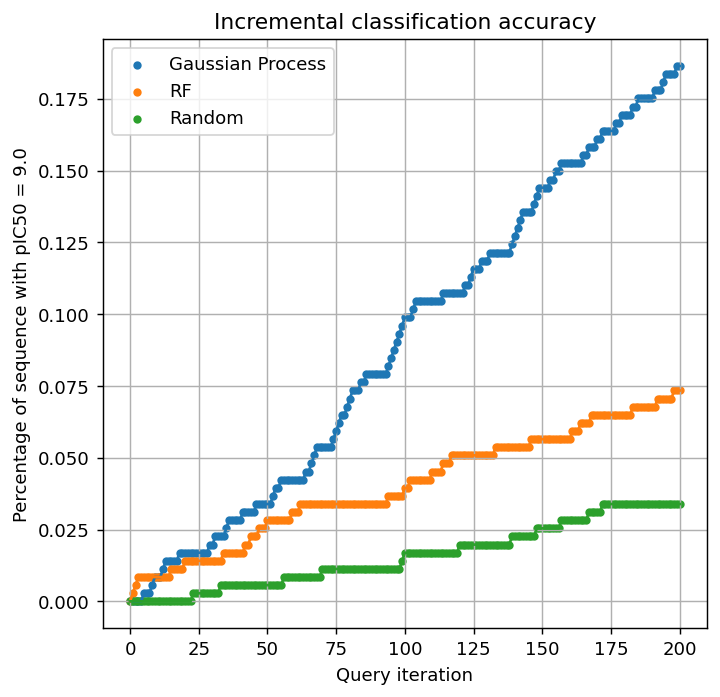

In [44]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(6, 6), dpi=130)

ax.plot(history_gp)
ax.scatter(range(len(history_gp)), history_gp, s=13, label = 'Gaussian Process')


ax.plot(history_rf)
ax.scatter(range(len(history_rf)), history_rf, s=13, label = 'RF')


ax.plot(history_rand)
ax.scatter(range(len(history_rand)), history_rand, s=13, label = 'Random')

ax.grid(True)
ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Percentage of sequence with pIC50 = 9.0')
ax.legend()

plt.show()

# 2.5. Create sequence logo based on sequences found with each querying strategies (5 points)

**A sequence logo is a graphical representation of the sequence conservation of amino acids in protein sequences), as amino acids that are important for functions are likely to be conserved. Hence, a sequence logo is a way to visualize such an importance. (Below is an example using all of the sequence of affinity 9.0.)**

**TODO**
- **Convert the each sets of sequences obtained by one of your optimization strategies to a sequence logo.** 


**Important: We are using [seqlogo](https://pypi.org/project/seqlogo/) to create sequence logo from our set of sequences. You can install `seqlogo` by entering the following command in your conda terminal:**
```
conda install -c bioconda seqlogo 
```

### Example

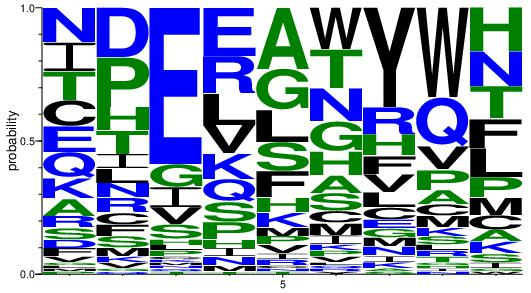

In [26]:
X_opt = X_pool[np.where(y_pool == 9)[0]]
ppm = np.sum(X_opt, axis = 0).reshape(20,9)
ppm /= np.sum(ppm, axis = 0)
ppm = seqlogo.Ppm(ppm, alphabet_type = 'AA')
seqlogo.seqlogo(ppm, ic_scale = False, format = 'jpeg', size = 'medium')

### Random

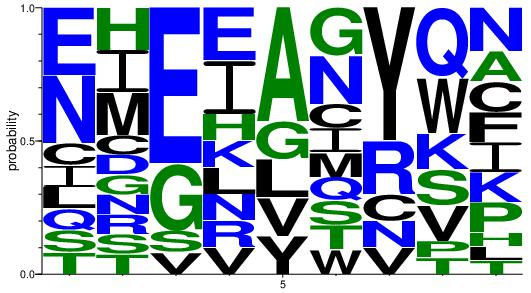

In [27]:
X_opt = np.array(optimal_points_rand)
ppm = np.sum(X_opt, axis=0).reshape(20,9) # convert encoding back to amino acids
ppm /= np.sum(ppm, axis = 0)
ppm = seqlogo.Ppm(ppm, alphabet_type = 'AA')
seqlogo.seqlogo(ppm, ic_scale = False, format = 'jpeg', size = 'medium')

### Gaussian Process

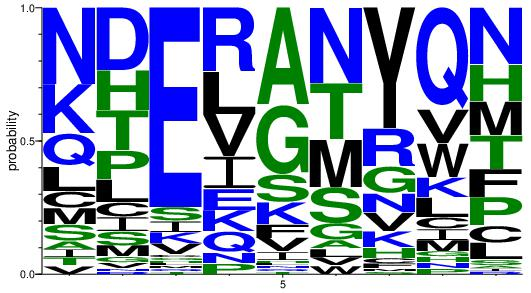

In [28]:
X_opt = np.array(optimal_points_gp)
ppm = np.sum(X_opt, axis=0).reshape(20,9) # convert encoding back to amino acids
ppm /= np.sum(ppm, axis = 0)
ppm = seqlogo.Ppm(ppm, alphabet_type = 'AA')
seqlogo.seqlogo(ppm, ic_scale = False, format = 'jpeg', size = 'medium')

### Random Forest

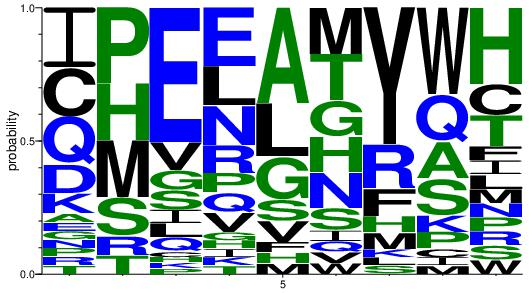

In [29]:
X_opt = np.array(optimal_points_rf)
ppm = np.sum(X_opt, axis=0).reshape(20,9) # convert encoding back to amino acids
ppm /= np.sum(ppm, axis = 0)
ppm = seqlogo.Ppm(ppm, alphabet_type = 'AA')
seqlogo.seqlogo(ppm, ic_scale = False, format = 'jpeg', size = 'medium')